# XAS Workflow Task 1

This notebook contains the first task of the XAS processing workflow. 

The break up of the task consist of the following steps 

| Task                            | Input                                         | Output
| -------------                   |-------------                                  | -----  
| Create Athena project      |                                               | 
| 1. Import data                |File: fes2_rt01_mar02.xmu                      | 
| 2. Normalisation              |Parameters: Pre-edge range = -117.00 to 30.000 |
| 3. Save Athena Project        |                                               |File: FeS2_01.prj

For more details about larch, see https://xraypy.github.io/xraylarch/xafs/


In [1]:
from larch.io import read_ascii, merge_groups
from pathlib import Path

from larch.symboltable import Group

#reading all with the same extension files from a dir
def get_files_list(source_dir, f_pattern):
    i_counter = 0
    source_dir = Path(source_dir)
    files_list = []
    for filepath in sorted(source_dir.glob(f_pattern)):
        i_counter += 1
        files_list.append(filepath)
    return files_list


# From BR demo at: https://vimeo.com/340207346 07:01
# the path to the files to be used
# file_path = "D:/PSDI/PSDI_test/psdi_data/pub_037/XAFS_prj/Sn K-edge/ascii/" # local
file_path = "C:/harwell/PSDI_test/wf_data/pub_037/XAFS_prj/Sn K-edge/ascii/" # pc
# file_path = "./"

# file_name_pattern = "26????_PtSn_OCH_Abu*"
file_name_pattern = "26????_PtSn_OCA_H2_Abu*"
# file_name_pattern = "*xmu"

file_names = get_files_list(file_path,file_name_pattern)

labels_sn_k = 'energy time i0 it iref mu lnitiref'
#labels_fes2 = "energy mu i0"

use_labels = labels_sn_k#labels_fes2
#file_names = ['fes2_rt01_mar02.xmu']

groups_list=[]

# read ascii files
# labels tell the reader how to name the resulting columns
# eneregy and mu are the most used labels

# if merge read in group and then merge
for a_file in file_names:
    a_group = read_ascii(a_file, labels=use_labels)
    groups_list.append(a_group)

# merge files
merged_xas = merge_groups (groups_list)

# using vars(fe_xas) we see that the object has the following properties: 
# path, filename, header, data, attrs, energy, xmu, i0
# vars(fe_xas)

In [2]:
get_files_list(Path(file_path),"26????_PtSn_OCH_Abu*")

[WindowsPath('C:/harwell/PSDI_test/wf_data/pub_037/XAFS_prj/Sn K-edge/ascii/262885_PtSn_OCH_Abu_1.dat'),
 WindowsPath('C:/harwell/PSDI_test/wf_data/pub_037/XAFS_prj/Sn K-edge/ascii/262886_PtSn_OCH_Abu_2.dat'),
 WindowsPath('C:/harwell/PSDI_test/wf_data/pub_037/XAFS_prj/Sn K-edge/ascii/262887_PtSn_OCH_Abu_3.dat'),
 WindowsPath('C:/harwell/PSDI_test/wf_data/pub_037/XAFS_prj/Sn K-edge/ascii/262888_PtSn_OCH_Abu_4.dat')]

In [3]:
# the following show the contents of each
for fe_xas in groups_list:
    print("path:\t\t", fe_xas.path)
    print("filename:\t", fe_xas.filename)
    print(fe_xas.header)
    print(fe_xas.data)
    print(fe_xas.attrs)
    print(fe_xas.array_labels)
    print('energy:', fe_xas.energy)
    print('i0:',fe_xas.i0)
    print('xmu:',fe_xas.mu)


path:		 C:\harwell\PSDI_test\wf_data\pub_037\XAFS_prj\Sn K-edge\ascii\262922_PtSn_OCA_H2_Abu_1.dat
filename:	 262922_PtSn_OCA_H2_Abu_1.dat
['# Diamond Light Source', '# Instrument: B18-CORE XAS Date: Thu, 28 Jul 2016 01:58:41 BST', '# Ring energy:   3.0', '# Ring current - start: 299.0', '# Primary slits:  vertical gap=  2.4; horizontal gap= 52.0; vertical offset=  0.4; horizontal offset= -1.0', '# Secondary slits:  vertical gap=  3.5; horizontal gap= 23.0; vertical offset=  5.3; horizontal offset= -14.5', '# OH Mirror Coating: Pt', '# White beam filter: 140um PyC', '# Crystal cut: Si(311)', '# PostDCM slits:  vertical gap= 18.0; horizontal gap= 28.0; vertical offset= -9.1; horizontal offset= -16.5', '# Experimental slits:  vertical gap= 28.6; horizontal gap= 45.0; vertical offset=  5.7; horizontal offset= -17.5', '# HR Mirror : out; Y: 37.8; Pitch:  0.3; Coating: Pt', '# Mirror 2: Pitch:  2.3; Height: -6.4; Yaw: -1.6; Bend:  0.8;', '# I0 Stanford sensitivity: 20 nA/V Offsets: 20 pA', 

## Calculate and plot $\mu$
Knowing the elements of the input data set it is possible to start manipulating and visualising the XAFS data. 

In this case $\mu$ is provided, so there is no need to calculate it, just rename it as mu (required by Larch for processing) and plot it agains the energy.


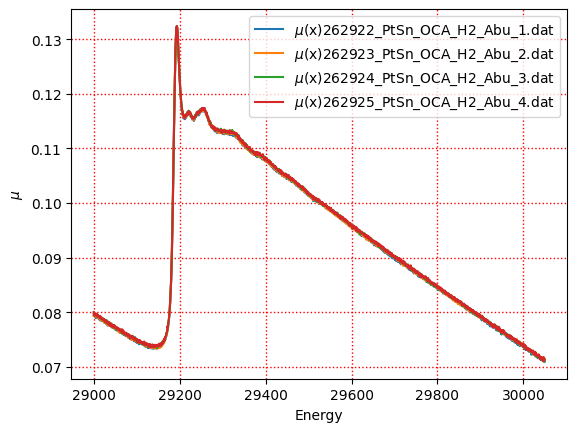

In [4]:
from numpy import log
from larch.utils import group2dict, dict2group

# Calculate mu 
def get_mu(xafs_group):
    # calculate mu
    mu_e = xafs_group.mu
    # get a dictionary from te group
    xafs_dict = group2dict(xafs_group)
    # add mu to the dictionary
    xafs_dict['mu'] = mu_e
    xafs_group = dict2group(xafs_dict)
    return xafs_group

for fe_xas in groups_list:
    fe_xas = get_mu(fe_xas)

    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.plot(fe_xas.energy, fe_xas.mu, label='$\mu$(x)' + fe_xas.filename )
    plt.xlabel('Energy')
    plt.ylabel('$\mu$')
    plt.legend() # include the leyend in the plot
    plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid


    

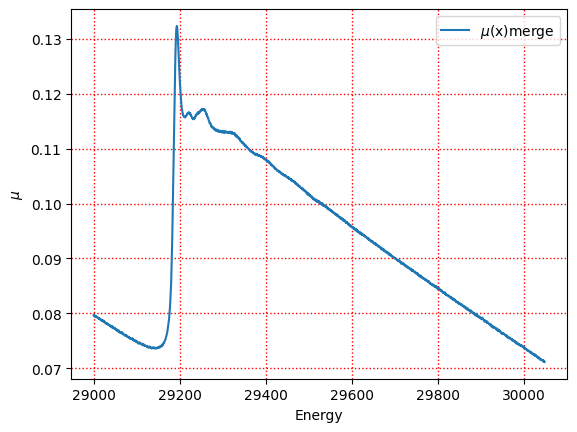

In [5]:
merged_xas = get_mu(merged_xas)
plt.plot(merged_xas.energy, merged_xas.mu, label='$\mu$(x)' + 'merge' )
plt.xlabel('Energy')
plt.ylabel('$\mu$')
plt.legend() # include the leyend in the plot
plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid

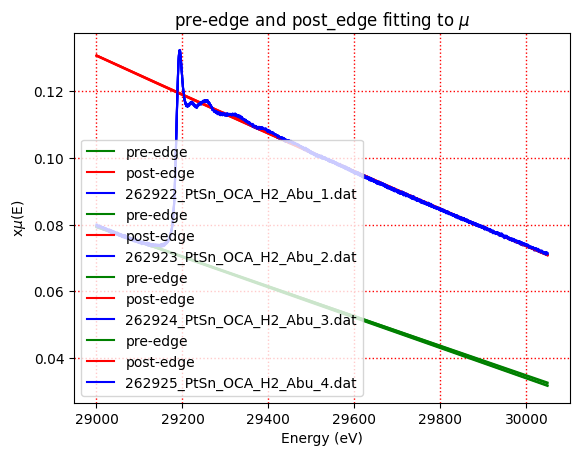

In [6]:
# https://vimeo.com/340207346 25:00
from larch.xafs import pre_edge
#calculate pre-edge and post edge and add them to group
# as with the basic workflow we want to avoid the data below E0 - 117.00

for fe_xas in groups_list:
    pre_edge(fe_xas, group=fe_xas, pre1=-150, pre2=-60)

    plt.plot(fe_xas.energy, fe_xas.pre_edge, 'g', label='pre-edge') # plot pre-edge in green
    plt.plot(fe_xas.energy, fe_xas.post_edge, 'r', label='post-edge')# plot post-edge in green
    plt.plot(fe_xas.energy, fe_xas.mu, 'b', label=fe_xas.filename) # plot mu in blue
    plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
    plt.xlabel('Energy (eV)') # label y graph
    plt.ylabel('x$\mu$(E)') # label y axis
    plt.title("pre-edge and post_edge fitting to $\mu$")
    plt.legend() # show legend

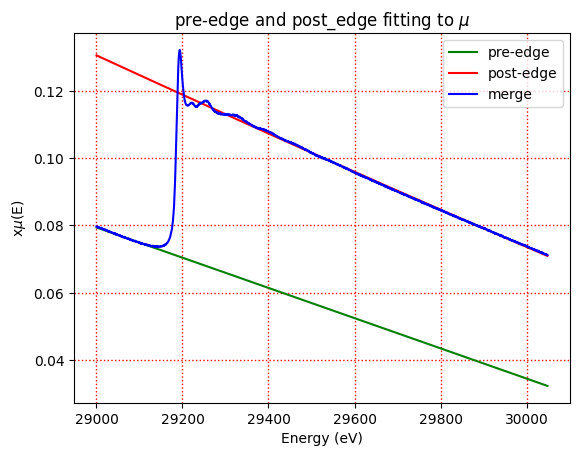

In [7]:
pre_edge(merged_xas, group=merged_xas, pre1=-150, pre2=-60)

plt.plot(merged_xas.energy, merged_xas.pre_edge, 'g', label='pre-edge') # plot pre-edge in green
plt.plot(merged_xas.energy, merged_xas.post_edge, 'r', label='post-edge')# plot post-edge in green
plt.plot(merged_xas.energy, merged_xas.mu, 'b', label="merge") # plot mu in blue
plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
plt.xlabel('Energy (eV)') # label y graph
plt.ylabel('x$\mu$(E)') # label y axis
plt.title("pre-edge and post_edge fitting to $\mu$")
plt.legend() # show legend

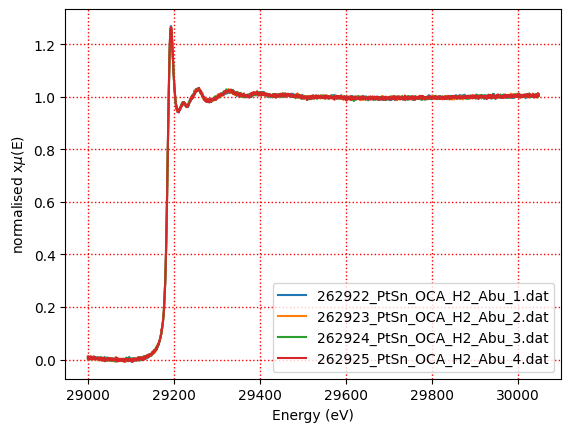

In [8]:
# https://vimeo.com/340207346 27:00
for fe_xas in groups_list:
    plt.plot(fe_xas.energy, fe_xas.flat, label=fe_xas.filename) # plot flattened and normalised energy
    plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
    plt.xlabel('Energy (eV)') # label y graph
    plt.ylabel(r'normalised x$\mu$(E)') # label y axis
    plt.legend() # show legend


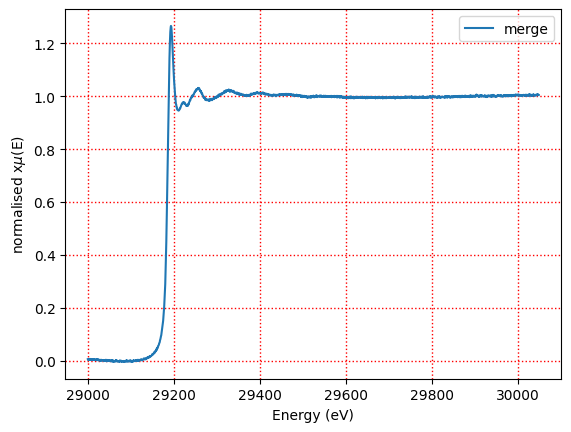

In [9]:

plt.plot(merged_xas.energy, merged_xas.flat, label='merge') # plot flattened and normalised energy
plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
plt.xlabel('Energy (eV)') # label y graph
plt.ylabel(r'normalised x$\mu$(E)') # label y axis
plt.legend() # show legend


In [10]:
# import the larch.io libraries for managing athena files
from larch.io import create_athena, read_athena, extract_athenagroup

# save as an athena project

project_name = 'PtSn_OCA_H2_Abu.prj'#'PtSn_OCH_Abu.prj' #'fes2_larch.prj'
fe_project = create_athena(project_name)
for fe_xas in groups_list:
    fe_project.add_group(fe_xas)
merged_xas.filename = "new_name"
merged_xas.path = "new_path"
fe_project.add_group(merged_xas)
fe_project.group_names[4]="merged group"
fe_project.save()
vars(fe_project)


IndexError: list assignment index out of range

In [ ]:
dir(merged_xas)